In [15]:
import pandas as pd

#biliotecas para extração e visualização do FFT ou Periodogram (PSD) 
import numpy as np
import pylab 
from scipy import signal
import matplotlib.pyplot as plt

import time # permite marcar o tempo de execução
start_time = time.time()

#def extract_fft_from_file(file_adress)

# reduz o samplig frequency 'ratio' vezes, tomando apenas 1 a cada 'ratio' sinais
ratio = 50
sampling_freq=50000/ratio # a ser usado no fft
skip=[i for i in range(0,250000) if i%ratio] # poupa apenas as linhas múltiplas de 'ratio' e lista as demais para exclusão

signals = pd.read_csv('mafaulda/imbalance/10g/61.8496.csv', header=None, 
                      names=['tachometer','ac1rad','ac1ax','ac1tg','ac2rad','ac2ax','ac2tg','microphone'],
                      skiprows=skip)
end_time = time.time()

print("Sinal com shape {} obtido em {} segundos".format(signals.shape, end_time-start_time))
print("a frequência de aquisição foi reduzida para {} Hz".format(sampling_freq))

Sinal com shape (5000, 8) obtido em 2.9205620288848877 segundos
a frequência de aquisição foi reduzida para 1000.0 Hz


## Análise exploratória dos sinais

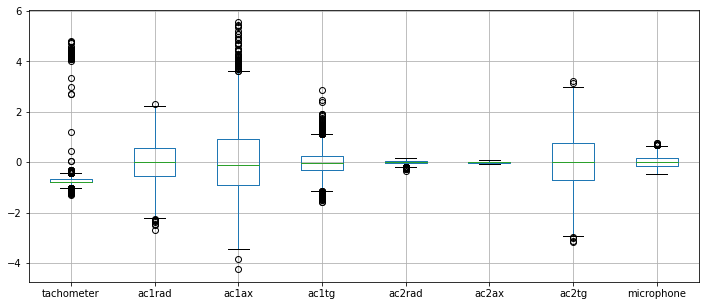

In [16]:
signals.boxplot(figsize=(12,5))

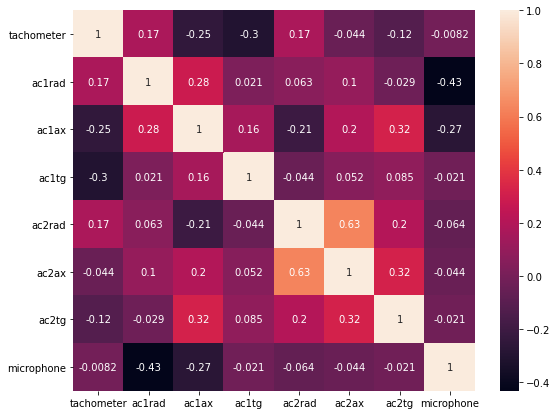

In [17]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(9,7)) 
sns.heatmap(signals.corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001256CA30310>,
      dtype=object)

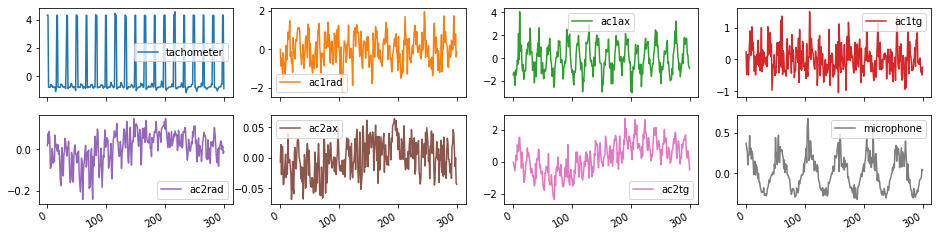

In [18]:
#signals.loc[:300,['ac1rad','ac1ax','ac1tg','tachometer',
#                  'ac2rad','ac2ax','ac2tg','microphone']].plot(subplots=True, layout=(2,4), figsize=(16,4))
signals.loc[:300].plot(subplots=True, layout=(2,4), figsize=(16,4))

In [19]:
#import simpleaudio as sa
import IPython.display as ipd
ipd.Audio(signals['tachometer'], rate=1000)

In [20]:
ipd.Audio(signals['microphone'], rate=1000)

In [21]:
ipd.Audio(signals['ac1rad'], rate=1000)

In [22]:
ipd.Audio(signals['ac1ax'], rate=1000)

In [23]:
ipd.Audio(signals['ac1tg'], rate=1000)

In [24]:
ipd.Audio(signals['ac2rad'], rate=1000)

In [25]:
ipd.Audio(signals['ac2ax'], rate=1000)

In [26]:
ipd.Audio(signals['ac2tg'], rate=1000)

## FFT via np.fft (sinal escolhido)

O sinal é real, logo apenas metade da transformada é necessária. São 2501 pontos 
A frequência fundamental do sinal é 13.6272 Hz


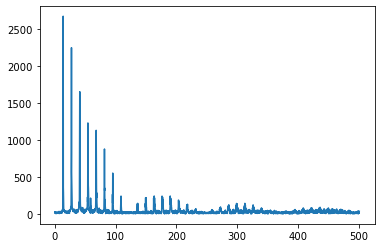

In [151]:
complex_fft = np.fft.rfft(signals['ac1rad'])
real_fft = np.abs(complex_fft)
freq_axis = np.linspace(0, sampling_freq/2+1, len(real_fft)) # a frequência de Nyquist é sampling_freq/2

print("O sinal é real, logo apenas metade da transformada é necessária. São {} pontos ".format(real_fft.shape[0]))
fundamental = freq_axis[real_fft.argmax()]
print('A frequência fundamental do sinal é {} Hz'.format(fundamental)) #frequencia fundamental

plt.plot(freq_axis,real_fft)
plt.show()

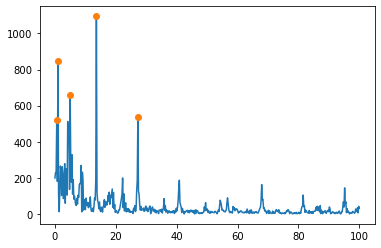

,freq,harmonic,amplitude
4,0.601,0.044,518.789
1,1.002,0.074,846.560
2,5.010,0.368,656.763
0,13.627,1.000,"1,094.650"
3,27.254,2.000,537.047


In [146]:
num_max = 5 # limiar de seleção
temp = np.argpartition(-real_fft, num_max) # ordenando parte dos sinais
biggest_args = temp[:num_max] # extraindo os índices dos maiores valores de amplitude

greatest_values = pd.DataFrame({'freq':freq_axis[biggest_args], 
                                'harmonic': freq_axis[biggest_args]/fundamental,
                                'amplitude':real_fft[biggest_args]})

greatest_values.sort_values('amplitude', ascending=False, ignore_index=True, inplace=True) # organiza os índices decrescendo 
                                                                                           # amplitude do sinal

pd.options.display.float_format = '{:,.3f}'.format


# plot com zoom
max_freq = 100
plt.plot(freq_axis[:max_freq*5], real_fft[:max_freq*5], 
         list(greatest_values['freq']), list(greatest_values['amplitude']), 'o')
plt.show()

# mostra tabela
greatest_values.sort_values('harmonic') # exibe na ordem de HARMONICOS crescentes
#greatest_values  # exibe na ordem de AMPLITUDES decrescentes